In [1]:
# load data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("data/heart.csv")
random_state= 47

In [2]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<Axes: >

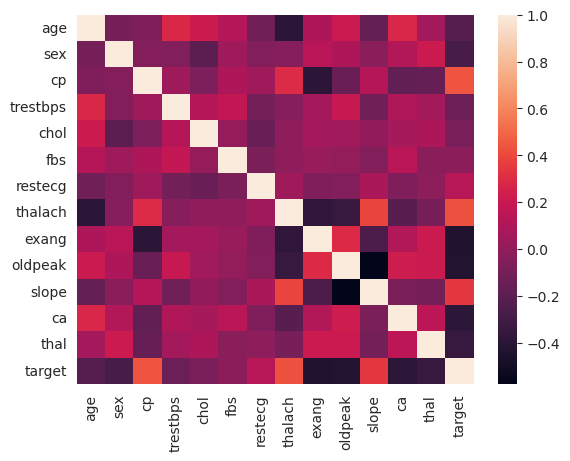

In [3]:
corr = data.corr()
sns.heatmap(corr)

Again as in previous homework we will use only 2 features with the highest correlation. That's why this plot don't have a big importance.

In [4]:
data.corr()["target"]

age        -0.225439
sex        -0.280937
cp          0.433798
trestbps   -0.144931
chol       -0.085239
fbs        -0.028046
restecg     0.137230
thalach     0.421741
exang      -0.436757
oldpeak    -0.430696
slope       0.345877
ca         -0.391724
thal       -0.344029
target      1.000000
Name: target, dtype: float64

Again as in previous homework I will choose:
 - thalach - The person's   maximum heart rate achieved
 - oldpeak - ST depression induced by exercise relative to rest    

In [5]:
# extract data
from sklearn.model_selection import train_test_split

selected_columns = data[["thalach", "oldpeak", "target"]] 
selected_columns.head()

X = selected_columns.drop(columns=["target"]).to_numpy()
y = selected_columns["target"].to_numpy()

X, X_test, y, y_test = train_test_split(X,y, test_size=0.3, random_state=random_state)

<Axes: xlabel='thalach', ylabel='oldpeak'>

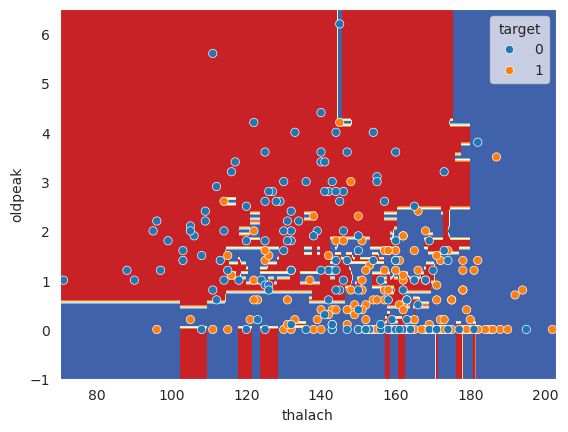

In [6]:
# decision boutry graph RandomForest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    random_state=random_state
)
clf.fit(X, y)

plot_step = 0.1

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

sns.scatterplot(x="thalach", y="oldpeak", hue="target", data = selected_columns)


Here could be seen similarities with DT although RF is more accurate, the delimitations are more precise. 

In [7]:
# measuring accuracy RF (not tunned)
from sklearn.metrics import accuracy_score

y_predicted = clf.predict(X_test)
accuracy_score(y_test, y_predicted)

0.6813186813186813

There is not a big difference between the decision tree boundary and random forest one, although it could be observed that random forest have a better precision. Decision Tree has a simpler geometry than RF . 

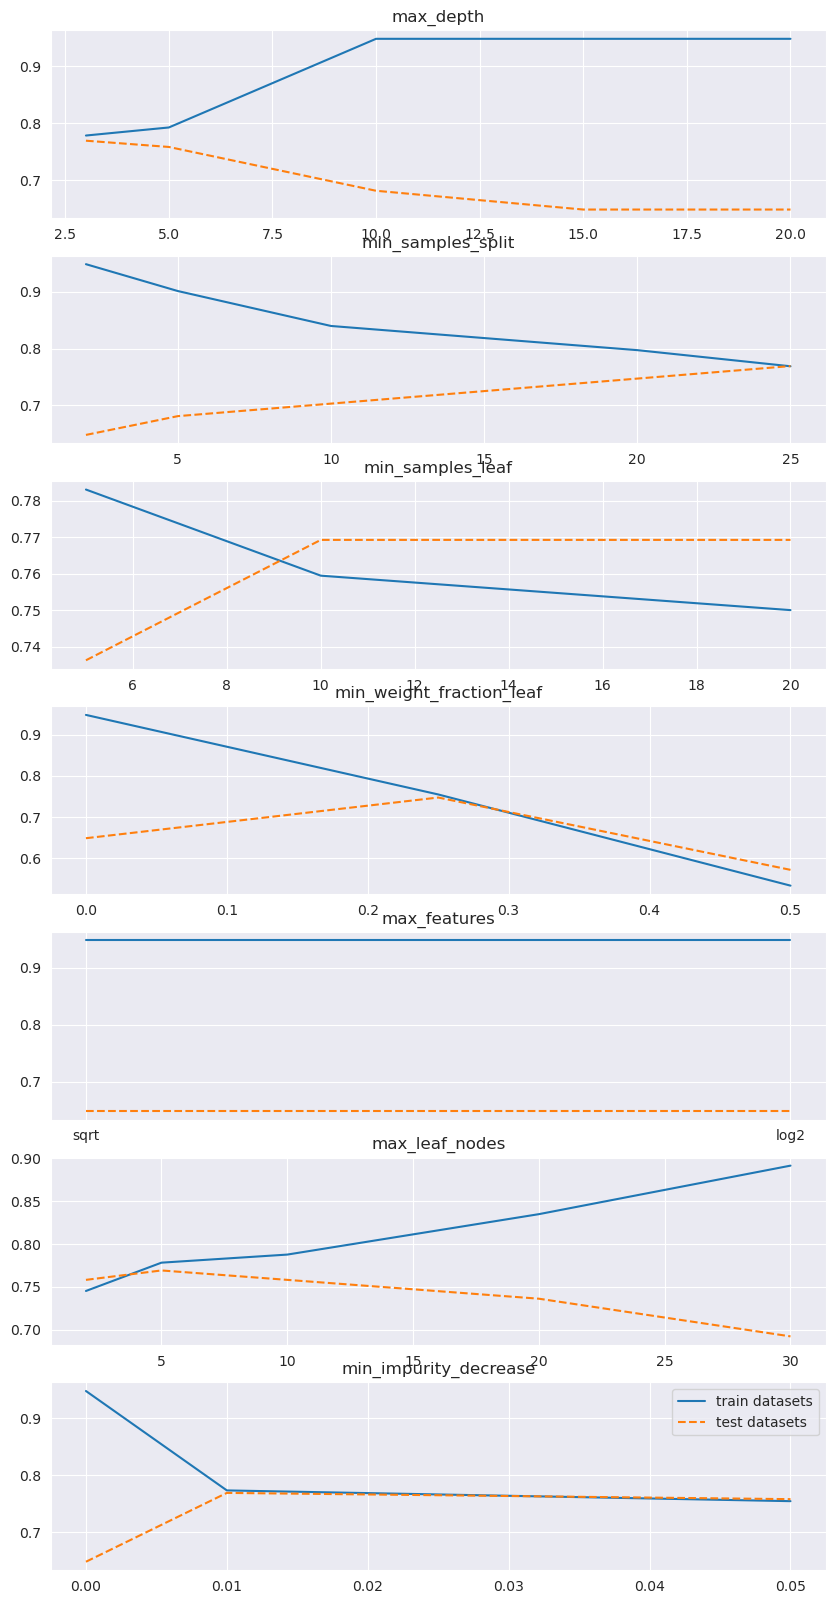

In [8]:

from sklearn.metrics import accuracy_score

random_state = 4242

# setting hyperparameters

params_grid = {
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10,20,25],
    'min_samples_leaf': [5,10,20],
    'min_weight_fraction_leaf': [0.0, 0.25, 0.5],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [2,5,10, 20, 30],
    'min_impurity_decrease': [0.0, 0.01, 0.05],
}



index = 0 
fig, axs = plt.subplots(len(params_grid),figsize=(10, 20))
for hyperparameter, values in params_grid.items():
    accuracies = []
    accuracies_test = []
    
    for value in values:
        init_parameters = {hyperparameter: value, "random_state": random_state}
        clf = RandomForestClassifier(**init_parameters)
        clf.fit(X, y) # train for each hyperparmeter
        y_predicted_data = clf.predict(X) 
        y_predicted_test = clf.predict(X_test)
        accuracy = accuracy_score(y, y_predicted_data)
        accuracy_test = accuracy_score(y_test, y_predicted_test)
        accuracies.append(accuracy)
        accuracies_test.append(accuracy_test)
    
    axs[index].plot( values, accuracies, label= "train")
    axs[index].plot( values, accuracies_test, linestyle='--', label ="test")
    axs[index].set_title(hyperparameter)
    index += 1 # crazy algorithms (o_O )
    plt.legend(["train datasets", "test datasets"])

There is not a huge difference between hyperparameters the DT and RF although there is an increase in accuracy for RF. 

In [9]:
# find the best parameters

from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

clf = RandomForestClassifier()

gridscv = GridSearchCV(clf, params_grid, cv=5, return_train_score=True, n_jobs=-1)

# Define the total number of iterations (combinations of hyperparameters)
total_iterations = len(list(gridscv.get_params()['param_grid'].values())[0])

# Fit the grid search object to the data with tqdm to show the loading bar
gridscv.fit(X, y)

print(gridscv.best_params_)

{'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.05, 'min_samples_leaf': 20, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.25}


In [10]:
from sklearn.tree import plot_tree

# train with best suited parameters

best_clf = RandomForestClassifier(
    **gridscv.best_params_,
) 

best_clf.fit(X,y)
y_predicted = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_predicted)
print(f"Accuracy RandomForest: {accuracy} (with hyperparameters tunning)")

Accuracy RandomForest: 0.7252747252747253 (with hyperparameters tunning)


| Model                          | Accuracy |
| ------------------------------ | -------- |
| LogisticRerresion              | 0.758    |
| DecisionTreeClassifire(tunned) | 0.791    |
| RandomForest                   | 0.681    |
| RandomForest(tunned)           | 0.769    |

### Conclusion

As mentioned in the SMLH Random Forest is a great choice for those who want to build the model fast and efficiently.  A strength that wasn't encountered here is that RF can handle missing values.  
